In [1]:
import pandas as pd

In [2]:
### If you are using colab, you can import google drive to save model checkpoints in a folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("GME.csv")

In [5]:
df.shape

(251, 7)

In [6]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
241,2021-12-16,38.232498,38.610001,35.532501,36.147499,36.147499,8659200
242,2021-12-17,35.937500,39.642502,34.832500,38.910000,38.910000,17226800
243,2021-12-20,38.297501,39.919998,37.424999,39.285000,39.285000,7314400
244,2021-12-21,39.264999,40.062500,38.785000,39.529999,39.529999,5720800
245,2021-12-22,39.582500,39.787498,38.029999,38.500000,38.500000,4188800
246,2021-12-23,38.500000,38.750000,36.505001,38.035000,38.035000,4222000
247,2021-12-27,38.000000,38.154999,35.000000,37.077499,37.077499,6454400
248,2021-12-28,36.875000,39.352501,36.602501,36.615002,36.615002,5324400
249,2021-12-29,36.962502,38.872501,35.535000,38.482498,38.482498,8149600
250,2021-12-30,37.750000,40.000000,37.500000,38.832500,38.832500,6247600


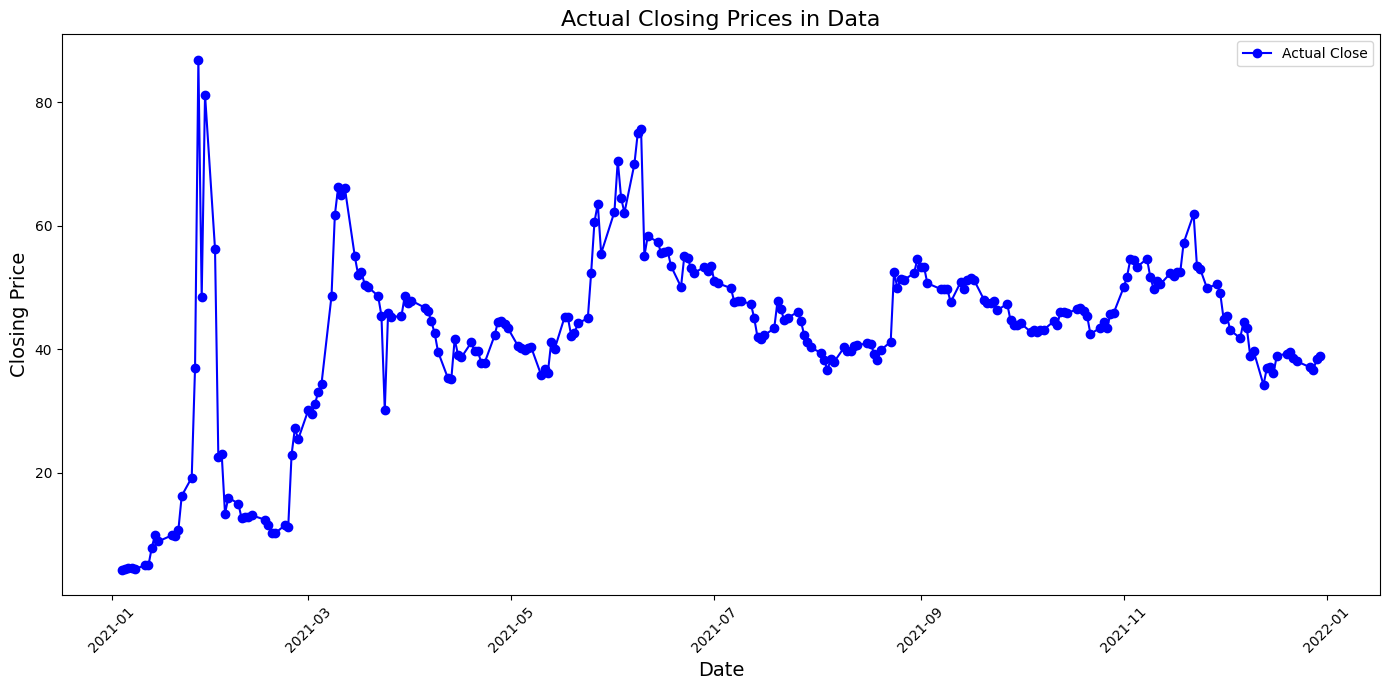

In [38]:
import matplotlib.pyplot as plt


# Ensure the 'Date' column is in datetime format for proper plotting
df['Date'] = pd.to_datetime(df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices in the training period
plt.plot(df['Date'], df['Close'], label='Actual Close', color='blue', marker='o')

# Adding title and labels with font size adjustments
plt.title('Actual Closing Prices in Data', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish the actual values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta

In [9]:
# Convert 'Date' to datetime and sort the DataFrame just in case
df['Date'] = pd.to_datetime(df['Date']) # This line converts the 'Date' column of the DataFrame df to datetime objects.
df.sort_values('Date', inplace=True)
#  The .values attribute returns the data as a NumPy array. The .reshape(-1, 1) function changes
#  the shape of this array to ensure it has two dimensions, with one column and as many rows as necessary.
close_prices = df['Close'].values.reshape(-1, 1)
# Scale the data -> you can use any appropriate scaling methodology
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_prices = scaler.fit_transform(close_prices)

In [36]:
scaled_close_prices.shape

(251, 1)

In [11]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [12]:
SEQUENCE_LENGTH = 20  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_close_prices, SEQUENCE_LENGTH)

In [16]:
print(X.shape)
print(y.shape)

(231, 20, 1)
(231, 1)


In [17]:
# Split the data into training and test sets (train on data until May 31st)
TRAIN_END_DATE = '2021-05-31'
train_indices = df[df['Date'] <= TRAIN_END_DATE].index
X_train, y_train = X[:train_indices[-1]-SEQUENCE_LENGTH], y[:train_indices[-1]-SEQUENCE_LENGTH]

In [19]:
print(X_train.shape, y_train.shape)

(81, 20, 1) (81, 1)



The model described is a neural network architecture using Long Short-Term Memory (LSTM) layers, commonly employed for sequence prediction problems such as time series forecasting. Here's a breakdown of each component of the model:

1. LSTM Layer with return_sequences=True
LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)):
This is the first layer in the model and an LSTM layer with 50 units. LSTM units are a type of recurrent neural network (RNN) cell that are effective in capturing long-term dependencies in sequence data.
return_sequences=True indicates that this layer returns the full sequence of outputs for each sample. This is necessary when stacking LSTM layers so that the subsequent LSTM layer can receive sequences of data as input.
input_shape=(X_train.shape[1], 1) specifies the shape of the input data. In this context, X_train.shape[1] refers to the sequence length (number of time steps), and 1 refers to the number of features per time step. This model is configured to work with a single feature per time step, typical for univariate time series forecasting (e.g., predicting a stock price based on past values of the stock price alone).


2. LSTM Layer with return_sequences=False
LSTM(50, return_sequences=False):
This is the second LSTM layer in the model, also with 50 units.
return_sequences=False means this layer only returns the output for the last time step in the input sequence. This is used when the subsequent layer expects a single vector per sample rather than a sequence of vectors. Since the next layer is a dense layer (fully connected layer), only the final output of the LSTM is needed.
This layer serves to further process the information extracted by the first LSTM layer, focusing on extracting features that will be useful for the final prediction.


3. Dense Layer
Dense(1):
This is a fully connected layer that follows the LSTM layers. It has a single unit.
The purpose of this layer is to output a single value, which is the predicted value for the next time step in the sequence. For example, in stock price prediction, this would be the predicted stock price for the next day.
Since this model is likely intended for regression (predicting a continuous value), there's no activation function specified, implying a linear activation is used by default. This allows the model to output values in the range of the real numbers.

In [20]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
3/3 [==============================] - 5s 11ms/step - loss: 0.2000
Epoch 2/20
3/3 [==============================] - 0s 8ms/step - loss: 0.1078
Epoch 3/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0450
Epoch 4/20
3/3 [==============================] - 0s 11ms/step - loss: 0.0306
Epoch 5/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0385
Epoch 6/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0253
Epoch 7/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0238
Epoch 8/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0270
Epoch 9/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0265
Epoch 10/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0239
Epoch 11/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0224
Epoch 12/20
3/3 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 13/20
3/3 [==============================] - 0s 8ms/step - loss: 

In [29]:
business_days = pd.date_range(start=pd.to_datetime(TRAIN_END_DATE) + timedelta(days=1),
                              periods=66, freq='B')

In [30]:
business_days

DatetimeIndex(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
               '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-10',
               '2021-06-11', '2021-06-14', '2021-06-15', '2021-06-16',
               '2021-06-17', '2021-06-18', '2021-06-21', '2021-06-22',
               '2021-06-23', '2021-06-24', '2021-06-25', '2021-06-28',
               '2021-06-29', '2021-06-30', '2021-07-01', '2021-07-02',
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16', '2021-07-19', '2021-07-20',
               '2021-07-21', '2021-07-22', '2021-07-23', '2021-07-26',
               '2021-07-27', '2021-07-28', '2021-07-29', '2021-07-30',
               '2021-08-02', '2021-08-03', '2021-08-04', '2021-08-05',
               '2021-08-06', '2021-08-09', '2021-08-10', '2021-08-11',
               '2021-08-12', '2021-08-13', '2021-08-16', '2021-08-17',
      

In [32]:
# Get the last sequence from the training data
last_sequence = X_train[-1].reshape((1, SEQUENCE_LENGTH, 1))

In [33]:
# Create a list to hold predictions
predictions = []

# Predict future prices
for i in range(len(business_days)):
    # Get the prediction (scaled value)
    current_prediction = model.predict(last_sequence)[0]

    # Append the prediction
    predictions.append(current_prediction)

    # Update the sequence
    last_sequence = np.roll(last_sequence, -1, axis=1)
    last_sequence[0, -1, 0] = current_prediction

# Inverse transform the predictions to get actual values
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Create a DataFrame with the predicted stock prices and dates
predictions_df = pd.DataFrame({
    'Date': business_days,
    'Predicted_Close': predicted_prices.flatten()
})

# Show the prediction results
print(predictions_df)

1/1 [==============================] - 0s 19ms/step
         Date  Predicted_Close
0  2021-06-01        42.921795
1  2021-06-02        43.467556
2  2021-06-03        43.755463
3  2021-06-04        43.877186
4  2021-06-07        43.886909
..        ...              ...
61 2021-08-25        40.915306
62 2021-08-26        40.908619
63 2021-08-27        40.902325
64 2021-08-30        40.896393
65 2021-08-31        40.890804

[66 rows x 2 columns]


In [ ]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df['Date'] = pd.to_datetime(df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

,Date,Predicted_Close
0,2021-06-01,44.666714
1,2021-06-02,43.204529
2,2021-06-03,42.247559
3,2021-06-04,41.620388
4,2021-06-07,41.209003
5,2021-06-08,40.939014
6,2021-06-09,40.761761
7,2021-06-10,40.645359
8,2021-06-11,40.568913
9,2021-06-14,40.518700


In [34]:
# Continue from the previous predictions_df creation code

# Ensure the 'Date' columns in both DataFrames are in the same format
df['Date'] = pd.to_datetime(df['Date'])
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

# Merge the predictions with the actual closing prices from 'df'
predictions_with_actuals_df = predictions_df.merge(df[['Date', 'Close']], on='Date', how='left')

# Rename columns for clarity
predictions_with_actuals_df.rename(columns={'Close': 'Actual_Close'}, inplace=True)

# Show the DataFrame with predictions and actual closing prices
print(predictions_with_actuals_df)

         Date  Predicted_Close  Actual_Close
0  2021-06-01        42.921795     62.255001
1  2021-06-02        43.467556     70.559998
2  2021-06-03        43.755463     64.544998
3  2021-06-04        43.877186     62.090000
4  2021-06-07        43.886909     70.002502
..        ...              ...           ...
61 2021-08-25        40.915306     49.912498
62 2021-08-26        40.908619     51.305000
63 2021-08-27        40.902325     51.237499
64 2021-08-30        40.896393     52.299999
65 2021-08-31        40.890804     54.560001

[66 rows x 3 columns]


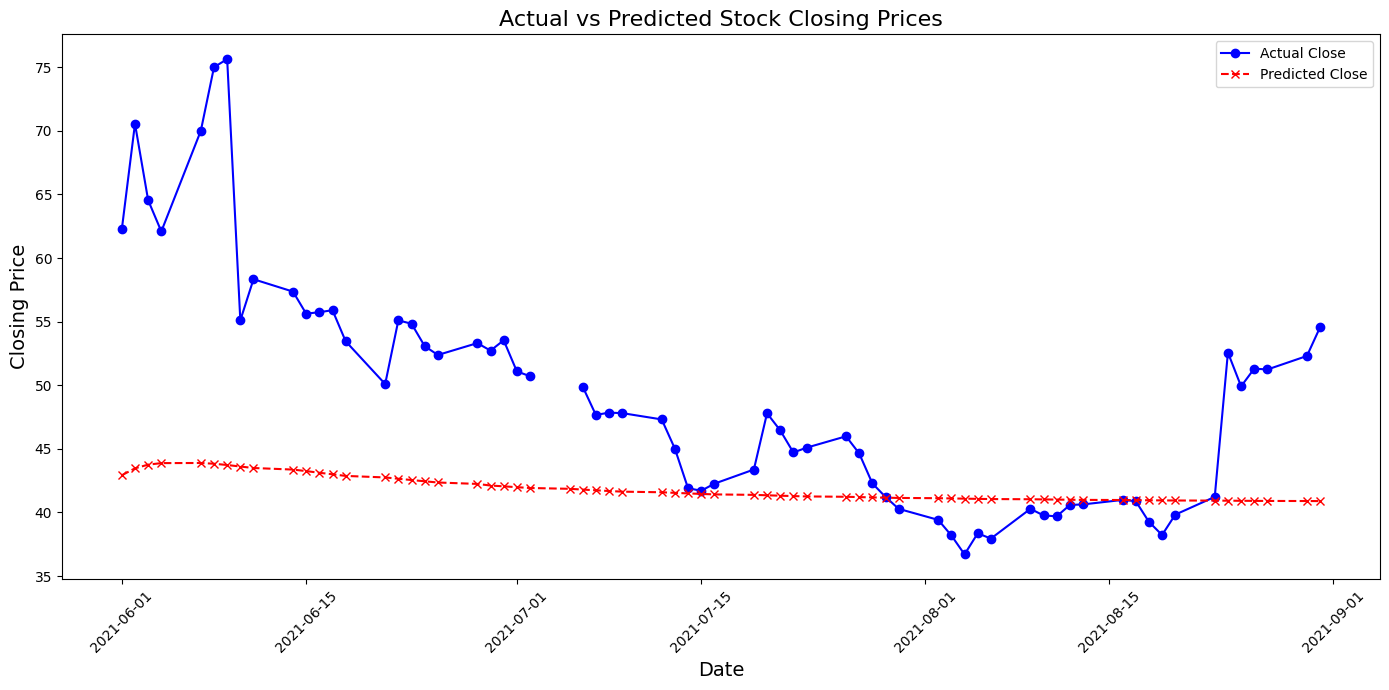

In [35]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format for proper plotting
predictions_with_actuals_df['Date'] = pd.to_datetime(predictions_with_actuals_df['Date'])

# Setting the plot size for better readability
plt.figure(figsize=(14, 7))

# Plotting the actual closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Actual_Close'], label='Actual Close', color='blue', marker='o')

# Plotting the predicted closing prices
plt.plot(predictions_with_actuals_df['Date'], predictions_with_actuals_df['Predicted_Close'], label='Predicted Close', color='red', linestyle='--', marker='x')

# Adding title and labels with font size adjustments
plt.title('Actual vs Predicted Stock Closing Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)

# Rotating date labels for better visibility
plt.xticks(rotation=45)

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()